In [58]:
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score,learning_curve, GroupKFold,GridSearchCV,StratifiedKFold
from sklearn.metrics import confusion_matrix



In [59]:
df =  pd.read_csv('../2017_07_07/TADPOLE_D1_D2.csv',low_memory=False)

In [60]:
#Name of the columns
df.head(0)


,RID,PTID,VISCODE,SITE,D1,D2,COLPROT,ORIGPROT,EXAMDATE,DX_bl,DXCHANGE,AGE,PTGENDER,PTEDUCAT,PTETHCAT,PTRACCAT,PTMARRY,APOE4,FDG,PIB,AV45,CDRSB,ADAS11,ADAS13,MMSE,RAVLT_immediate,RAVLT_learning,RAVLT_forgetting,RAVLT_perc_forgetting,FAQ,MOCA,EcogPtMem,EcogPtLang,EcogPtVisspat,EcogPtPlan,EcogPtOrgan,EcogPtDivatt,EcogPtTotal,EcogSPMem,EcogSPLang,EcogSPVisspat,EcogSPPlan,EcogSPOrgan,EcogSPDivatt,EcogSPTotal,FLDSTRENG,FSVERSION,Ventricles,Hippocampus,WholeBrain,Entorhinal,Fusiform,MidTemp,ICV,DX,EXAMDATE_bl,CDRSB_bl,ADAS11_bl,ADAS13_bl,MMSE_bl,RAVLT_immediate_bl,RAVLT_learning_bl,RAVLT_forgetting_bl,RAVLT_perc_forgetting_bl,FAQ_bl,FLDSTRENG_bl,FSVERSION_bl,Ventricles_bl,Hippocampus_bl,WholeBrain_bl,Entorhinal_bl,Fusiform_bl,MidTemp_bl,ICV_bl,MOCA_bl,EcogPtMem_bl,EcogPtLang_bl,EcogPtVisspat_bl,EcogPtPlan_bl,EcogPtOrgan_bl,EcogPtDivatt_bl,EcogPtTotal_bl,EcogSPMem_bl,EcogSPLang_bl,EcogSPVisspat_bl,EcogSPPlan_bl,EcogSPOrgan_bl,EcogSPDivatt_bl,EcogSPTotal_bl,FDG_bl,PIB_bl,AV45_bl,Years_bl,Month_bl,Month,M,update_stamp,EXAMDATE_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,VERSION_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,FLDSTRENG_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,LONISID_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,LONIUID_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,IMAGEUID_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,RUNDATE_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,STATUS_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,BASETP1_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,BASETP2_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,BASETP3_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,BASETP4_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,BASETP5_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,BASETP6_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,BASETP7_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,BASETP8_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,OVERALLQC_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,TEMPQC_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,FRONTQC_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,PARQC_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,INSULAQC_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,OCCQC_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,BGQC_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,CWMQC_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,VENTQC_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,ST100SV_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,ST101SV_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,ST102CV_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,ST102SA_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,ST102TA_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,ST102TS_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,ST103CV_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,ST103SA_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,ST103TA_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,ST103TS_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,ST104CV_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,ST104SA_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,ST104TA_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,ST104TS_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,ST105CV_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,ST105SA_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,ST105TA_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,ST105TS_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,ST106CV_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,ST106SA_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,ST106TA_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,ST106TS_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,ST107CV_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,ST107SA_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,ST107TA_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,ST107TS_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,ST108CV_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,ST108SA_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,ST108TA_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,ST108TS_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,ST109CV_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,ST109SA_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,ST109TA_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,ST109TS_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,ST10CV_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,ST110CV_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,ST110SA_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,ST110TA_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,ST110TS_UCSFFSL_02_01

In [61]:
#Do some test on the data

print(df['DX'].head())
print(df['DX_bl'].head())
print(df['EXAMDATE_BAIPETNMRC_09_12_16'].unique())
print(df['PTETHCAT'].head(1))
print(df['ABETA_UPENNBIOMK9_04_19_17'].head(1))

0          NL
1    Dementia
2    Dementia
3    Dementia
4    Dementia
Name: DX, dtype: object
0    CN
1    AD
2    AD
3    AD
4    AD
Name: DX_bl, dtype: object
['2005-09-22' '2006-03-13' '2006-09-12' ... '2016-04-21' '2016-04-12'
 '2016-04-27']
0    Not Hisp/Latino
Name: PTETHCAT, dtype: object
0     
Name: ABETA_UPENNBIOMK9_04_19_17, dtype: object


In [62]:
pd.set_option('display.max_columns', None)

#important columns to convert to int: EXAMDATE	DX_bl	DXCHANGE	AGE	PTGENDER	PTEDUCAT	PTETHCAT	PTRACCAT	PTMARRY	

In [63]:
print(df['DXCHANGE'].head(1))
'1=Stable:NL to NL, 2=Stable:MCI to MCI, 3=Stable:AD to AD, ' 
'4=Conv:NL to MCI, 5=Conv:MCI to AD, 6=Conv:NL to AD, ' 
'7=Rev:MCI to NL, 8=Rev:AD to MCI, 9=Rev:AD to NL, -1=Not available'

0    1.0
Name: DXCHANGE, dtype: float64


'7=Rev:MCI to NL, 8=Rev:AD to MCI, 9=Rev:AD to NL, -1=Not available'

In [64]:
data = df
print(data.shape)

#Convert to numeric
data['PTGENDER']= data['PTGENDER'].replace(['Male','Female'],[1,0])
data['APOE4']= data['APOE4'].astype(float)
data['AGE']= data['AGE'].astype(float)
data['PTETHCAT']= data['PTETHCAT'].replace(['Hisp/Latino','Not Hisp/Latino','Unknown'],[2,1,0]).astype(int)
data['PTMARRY']= data['PTMARRY'].replace(['Married','Widowed','Divorced','Never married','Unknown'],[0,1,2,3,4]).astype(int)
data['PTRACCAT'] = data['PTRACCAT'].replace(['White','More than one','Black','Asian', 'Am Indian/Alaskan','Hawaiian/Other PI', 'Unknown'],[0,1,2,3,4,5,6]).astype(int)
data['DX_bl'] = data['DX_bl'].replace(['CN' ,'AD' ,'LMCI' ,'EMCI' ,'SMC'],['0','1','2','3','4']).astype(int)
data['DX'] = data['DX'].replace(['NL' ,'Dementia', 'MCI', 'NL to MCI', 'MCI to Dementia', 'MCI to NL','Dementia to MCI','nan' ,'NL to Dementia'],['1','3','4','5','6','7','8','9','10'])
data['DX']=data['DX'].fillna(0)

data['EXAMDATE_bl'] = pd.to_datetime(data['EXAMDATE_bl']).dt.strftime("%Y%m%d").astype(int)
print(data['EXAMDATE_bl'].head(1))

data['EXAMDATE'] = pd.to_datetime(data['EXAMDATE']).dt.strftime("%Y%m%d").astype(int)
print(data['EXAMDATE'].head(1))

#Print some data to check if it is correct
print(data['DX_bl'].head(1))
print(data['DX'].unique())

# drop the columns in data they ate objet type
data = data.select_dtypes(exclude=['object'])
print(data.shape)


(12741, 1907)
0    20050908
Name: EXAMDATE_bl, dtype: int32
0    20050908
Name: EXAMDATE, dtype: int32
0    0
Name: DX_bl, dtype: int32
['1' '3' '4' '5' '6' '7' '8' 0 '10']
(12741, 87)


The main measures to be predicted: DX, ADAS13, Ventricles
Cognitive tests: CDRSB, ADAS11, MMSE, RAVLT_immediate
MRI measures: Hippocampus, WholeBrain, Entorhinal, MidTemp
PET measures: FDG, AV45
CSF measures: ABETA_UPENNBIOMK9_04_19_17  (amyloid-beta level in CSF), TAU_UPENNBIOMK9_04_19_17 (tau level), PTAU_UPENNBIOMK9_04_19_17 (phosphorylated tau level)
Risk factors: APOE4, AGE

In [65]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12741 entries, 0 to 12740
Data columns (total 87 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   RID                       12741 non-null  int64  
 1   SITE                      12741 non-null  int64  
 2   D1                        12741 non-null  int64  
 3   D2                        12741 non-null  int64  
 4   EXAMDATE                  12741 non-null  int32  
 5   DX_bl                     12741 non-null  int32  
 6   DXCHANGE                  8892 non-null   float64
 7   AGE                       12741 non-null  float64
 8   PTGENDER                  12741 non-null  int64  
 9   PTEDUCAT                  12741 non-null  int64  
 10  PTETHCAT                  12741 non-null  int32  
 11  PTRACCAT                  12741 non-null  int32  
 12  PTMARRY                   12741 non-null  int32  
 13  APOE4                     12729 non-null  float64
 14  FDG   

In [66]:
# Algorithme des k plus proches voisins
model = KNeighborsClassifier()
y = data['DXCHANGE']
Y = data['DX_bl']
X = data.drop('DXCHANGE', axis=1)
y = np.nan_to_num(y)
X= np.nan_to_num(X)
Y = np.nan_to_num(Y)

In [67]:

#Split the data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=5)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=5)

model.fit(X_train,y_train)
print(model.score(X_train,y_train))
print(model.score(X_test,y_test))

model.fit(X_train,Y_train)
print(model.score(X_train,Y_train))
print(model.score(X_test,Y_test))

0.717948717948718
0.6062745098039216
0.8538287109715681
0.735686274509804


In [68]:
#Take the best parameters for the model
param_grid = {'n_neighbors': np.arange(1, 25),'metric': ['euclidean', 'manhattan']}
grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5)
grid.fit(X_train, y_train)


C:\Users\antoi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])})

In [69]:

grid2 = grid
grid2.fit(X_train, Y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])})

In [70]:
# Print the tuned parameters and score
print(grid.best_params_)
print(grid.best_score_)
print(grid.best_estimator_)

model = grid.best_estimator_
print(model.score(X_train,y_train))
print(model.score(X_test,y_test))


{'metric': 'manhattan', 'n_neighbors': 1}
0.9052842299694571
KNeighborsClassifier(metric='manhattan', n_neighbors=1)
0.29338915053200765
0.312156862745098


In [71]:
# Print the tuned parameters and score of the current diagnostic
print(grid2.best_params_)
print(grid2.best_score_)
print(grid2.best_estimator_)

model2 = grid2.best_estimator_
print(model2.score(X_train,Y_train))
print(model2.score(X_test,Y_test))

{'metric': 'manhattan', 'n_neighbors': 1}
0.9052842299694571
KNeighborsClassifier(metric='manhattan', n_neighbors=1)
1.0
0.927843137254902


In [72]:
#View the error of the model
confusion_matrix(y_test, model.predict(X_test))


array([[148,  35, 123,  79,   6,   0,   0,   0,   0],
       [224,   4,  15,   6,  19,   0,   0,   0,   0],
       [ 13,   6, 244, 132,   1,   0,   0,   0,   0],
       [ 13,  84,  65,   1,   0,   0,   0,   0,   0],
       [  5,   0,   2,   1,   1,   0,   0,   0,   0],
       [  0,   1,  37,   1,   0,   0,   0,   0,   0],
       [  1,   0,   0,   0,   0,   0,   0,   0,   0],
       [  1,   0,   3,   3,   0,   0,   0,   0,   0],
       [  0,   1,   0,   0,   0,   0,   0,   0,   0]], dtype=int64)

In [73]:

confusion_matrix(Y_test, model2.predict(X_test))


array([[370,   3,  10,   4,   1],
       [ 20, 112,  11,   3,   0],
       [  9,  13, 465,   2,   1],
       [  3,   1,   3, 212,   1],
       [  3,   2,   0,   2,  24]], dtype=int64)

In [74]:
#the learning curve
N, train_score,val_score = learning_curve(model,X_train,y_train,train_sizes = np.linspace(0.2,1.0,5),cv=5)

C:\Users\antoi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


In [75]:
#the learning curve
N2, train_score2,val_score2 = learning_curve(model2,X_train,Y_train,train_sizes = np.linspace(0.2,1.0,5),cv=5)

[1834 3668 5503 7337 9172]


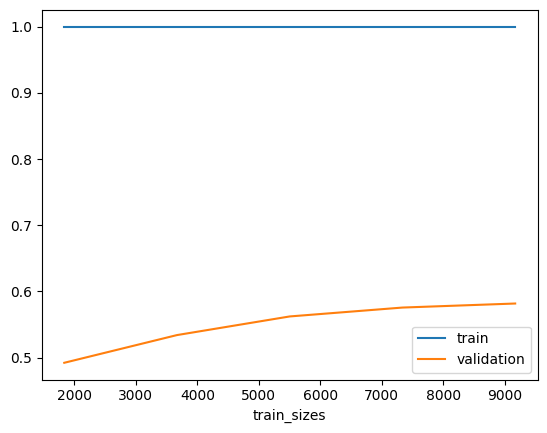

In [76]:
#Plot the learning curve
print(N)
plt.plot(N,train_score.mean(axis=1), label='train')
plt.plot(N,val_score.mean(axis=1), label='validation')
plt.xlabel('train_sizes')
plt.legend()


[1834 3668 5503 7337 9172]


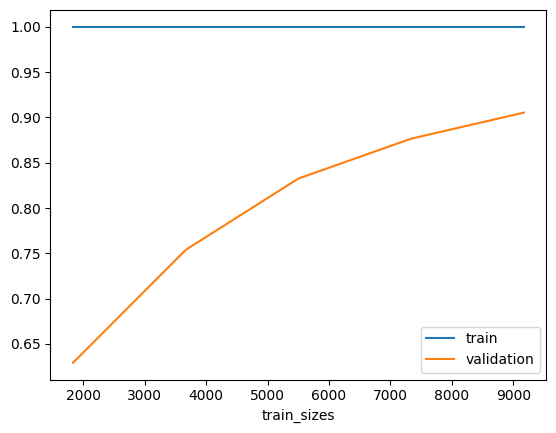

In [77]:
#Plot the learning curve
print(N2)
plt.plot(N2,train_score.mean(axis=1), label='train')
plt.plot(N2,val_score2.mean(axis=1), label='validation')
plt.xlabel('train_sizes')
plt.legend()

In [78]:
#Chose the best split for the data
cv =  GroupKFold(5).get_n_splits(X,y,groups=X[:,5])
cross_val_score(model,X,y,cv=cv)

C:\Users\antoi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


array([0.33150255, 0.38265306, 0.28728414, 0.44387755, 0.42268446])

In [80]:
cv= StratifiedKFold(5)
cross_val_score(model,X,y,cv=cv)

C:\Users\antoi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


array([0.33150255, 0.38265306, 0.28728414, 0.44387755, 0.42268446])

In [81]:
cv2= StratifiedKFold(5)
cross_val_score(model2,X,Y,cv=cv2)

array([0.62612789, 0.68602826, 0.73744113, 0.69544741, 0.61852433])

In [79]:
def sick(model,PTGENDER=1,AGE=10,PTEDUCAT=4,APOE4=0):
    x= np.array([PTGENDER,AGE,PTEDUCAT,APOE4]).reshape(1,4)
    print(model.predict(x))
    print(model.predict_proba(x))